# Knowledge Graph Summary Stats

## Setup notebook

In [1]:
# Imports
import sys
if '../' not in sys.path:
    sys.path.append("../")
%load_ext dotenv
%dotenv

import os

from graphdatascience import GraphDataScience
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/ec2-user/miniconda3/envs/rnalab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# Config

NEO4J_URI = os.environ.get('NEO4J_URI')
NEO4J_USER = os.environ.get('NEO4J_USER')
NEO4J_PASSWORD = os.environ.get('NEO4J_PASSWORD')


METADATA_PROJECTION_NAME = 'summary-stats'
METADATA_TYPE = 'taxon' # 'tissue', 'taxon', 'sotu'
RANDOM_SEED = 42

In [3]:
# Db helpers

def get_gds_client():
    return GraphDataScience(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def query_gds(query):
    client = get_gds_client()
    return client.run_cypher(query)

## Create projection

In [19]:
# Create projection

tissue_query = f'''
    MATCH (source)
    WHERE source:Tissue
    OPTIONAL MATCH (source)-[r:HAS_PARENT]->(target)
    WHERE target:Tissue
    WITH gds.graph.project(
        '{METADATA_PROJECTION_NAME}',
        source,
        target,
        {{}},
        {{
            undirectedRelationshipTypes: ['*']
        }}
    ) as g
    RETURN g
'''

taxon_query = f'''
    MATCH (source)
    WHERE source:Taxon
    OPTIONAL MATCH (source)-[r:HAS_PARENT]->(target)
    WHERE target:Taxon
    WITH gds.graph.project(
        '{METADATA_PROJECTION_NAME}',
        source,
        target,
        {{}},
        {{
            undirectedRelationshipTypes: ['*']
        }}
    ) as g
    RETURN g
'''

sotu_query = f'''
    MATCH (source)
    WHERE source:SOTU
    OPTIONAL MATCH (source)-[r:SEQUENCE_ALIGNMENT]->(target)
    WHERE target:SOTU
    WITH gds.graph.project(
        '{METADATA_PROJECTION_NAME}',
        source,
        target,
        {{}},
        {{
            undirectedRelationshipTypes: ['*']
        }}
    ) as g
    RETURN g
'''


gds = get_gds_client()

if gds.graph.exists(METADATA_PROJECTION_NAME)['exists']:
    gds.graph.drop(gds.graph.get(METADATA_PROJECTION_NAME))


if METADATA_TYPE == 'tissue':
    projection = query_gds(tissue_query)
elif METADATA_TYPE == 'taxon':
    projection = query_gds(taxon_query)
elif METADATA_TYPE == 'sotu':
    projection = query_gds(sotu_query)
else:
    raise ValueError('Invalid metadata type')

display(projection['g'][0])
display(f'Total nodes: {projection["g"][0]["nodeCount"]}')
display(f'Total relationships: {projection["g"][0]["relationshipCount"]}')

{'relationshipCount': 5003746,
 'graphName': 'summary-stats',
 'query': "\n    MATCH (source)\n    WHERE source:Taxon\n    OPTIONAL MATCH (source)-[r:HAS_PARENT]->(target)\n    WHERE target:Taxon\n    WITH gds.graph.project(\n        'summary-stats',\n        source,\n        target,\n        {},\n        {\n            undirectedRelationshipTypes: ['*']\n        }\n    ) as g\n    RETURN g\n",
 'projectMillis': 16235,
 'configuration': {'readConcurrency': 4,
  'undirectedRelationshipTypes': ['*'],
  'jobId': 'ef6fb9f5-591b-4244-addc-458559e52548',
  'logProgress': True,
  'relationshipCount': -1,
  'inverseIndexedRelationshipTypes': [],
  'creationTime': neo4j.time.DateTime(2024, 10, 7, 2, 0, 25, 558854794, tzinfo=<UTC>),
  'validateRelationships': False,
  'sudo': False,
  'nodeCount': -1},
 'nodeCount': 2501873}

'Total nodes: 2501873'

'Total relationships: 5003746'

In [20]:
display(projection['g'][0])
display(f'Total nodes: {projection["g"][0]["nodeCount"]}')
display(f'Total relationships: {projection["g"][0]["relationshipCount"]}')

{'relationshipCount': 5003746,
 'graphName': 'summary-stats',
 'query': "\n    MATCH (source)\n    WHERE source:Taxon\n    OPTIONAL MATCH (source)-[r:HAS_PARENT]->(target)\n    WHERE target:Taxon\n    WITH gds.graph.project(\n        'summary-stats',\n        source,\n        target,\n        {},\n        {\n            undirectedRelationshipTypes: ['*']\n        }\n    ) as g\n    RETURN g\n",
 'projectMillis': 16235,
 'configuration': {'readConcurrency': 4,
  'undirectedRelationshipTypes': ['*'],
  'jobId': 'ef6fb9f5-591b-4244-addc-458559e52548',
  'logProgress': True,
  'relationshipCount': -1,
  'inverseIndexedRelationshipTypes': [],
  'creationTime': neo4j.time.DateTime(2024, 10, 7, 2, 0, 25, 558854794, tzinfo=<UTC>),
  'validateRelationships': False,
  'sudo': False,
  'nodeCount': -1},
 'nodeCount': 2501873}

'Total nodes: 2501873'

'Total relationships: 5003746'

## Summary stats

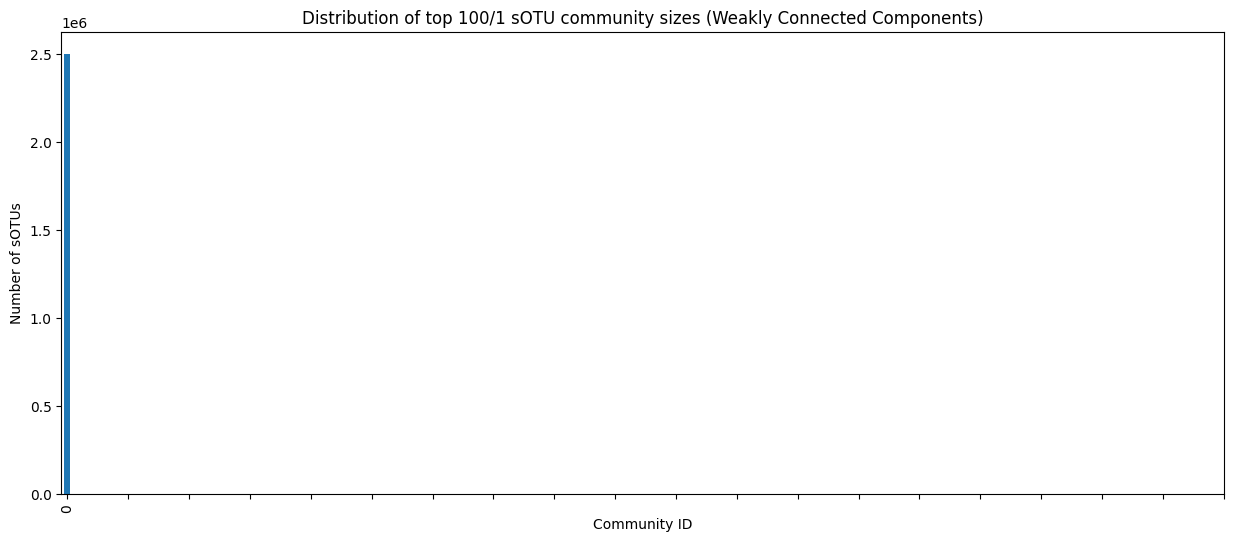

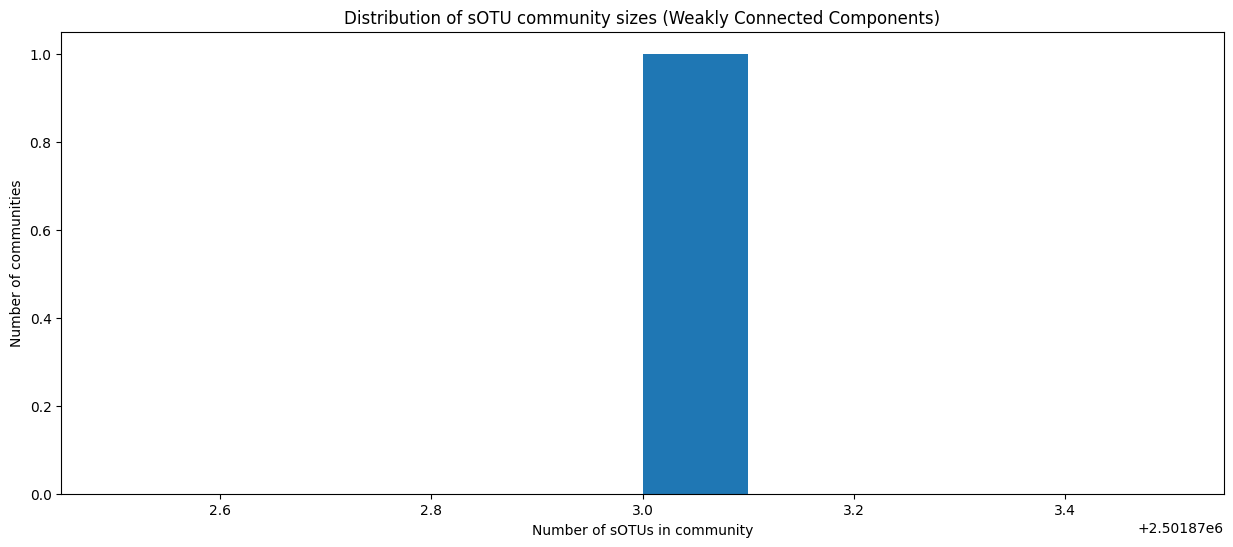

,nodeId,componentId,communityId
0,8755885,0,0
1,9655883,0,0
2,8755886,0,0
3,9850834,0,0
4,8755887,0,0
...,...,...,...
2501868,11257751,0,0
2501869,11257752,0,0
2501870,11257753,0,0
2501871,11257754,0,0


communityId
0    2501873
dtype: int64

Number of communities with only one sOTU: 0
Number of communities with more than one sOTU: 1


In [14]:
# Run community analysis

def get_wcc_communities(graph, seed_property=None, edge_weight_property=None):
    communities = gds.wcc.stream(
        graph,
        relationshipWeightProperty=edge_weight_property,
        seedProperty=seed_property,
    )
    return communities

def get_scc_communities(graph, seed_property=None, edge_weight_property=None):
    communities = gds.scc.stream(
        graph,
    )
    return communities


def get_community_sizes(communities):
    community_sizes = communities.groupby('communityId').size()
    community_sizes = pd.Series(community_sizes)
    community_sizes = community_sizes.sort_values(ascending=False)
    return community_sizes

def plot_communities(communities, community_algo):
    community_sizes = get_community_sizes(communities)
    num_unique_communities = len(community_sizes)

    plt.figure(figsize=(15, 6))
    top_n = 100
    community_sizes.plot(kind='bar')
    plt.xlabel('Community ID')
    plt.ylabel('Number of sOTUs')
    plt.title(f'Distribution of top {top_n}/{num_unique_communities} sOTU community sizes ({community_algo})')
    plt.xticks(np.arange(0, top_n, 5))
    plt.show()


def plot_communities_histogram(communities, community_algo):
    community_sizes = get_community_sizes(communities)
    plt.figure(figsize=(15, 6))
    community_sizes.plot(kind='hist')
    plt.xlabel('Number of sOTUs in community')
    plt.ylabel('Number of communities')
    plt.title(f'Distribution of sOTU community sizes ({community_algo})')
    plt.show()


gds = get_gds_client()
projection = gds.graph.get(METADATA_PROJECTION_NAME)
community_algo = 'Weakly Connected Components'
communities = get_wcc_communities(projection)
# communities = get_scc_communities(projection)

if 'componentId' in communities.columns:
    communities['communityId'] = communities['componentId']

# denormalize communities using values.communityIds for multi-community nodes
if 'values' in communities.columns:
    communities['values'] = communities['values'].apply(lambda x: x['communityIds'])
    communities = communities.explode('values')
    communities['communityId'] = communities['values']
    communities = communities.drop(columns=['values'])

plot_communities(communities, community_algo)
plot_communities_histogram(communities, community_algo)

display(communities)
community_sizes = get_community_sizes(communities)
# count number of communities with only one sOTU
num_singletons = len(community_sizes[community_sizes == 1])
# count number of communities with more than one sOTU
num_non_singletons = len(community_sizes[community_sizes > 1])

display(community_sizes.head())
print(f'Number of communities with only one sOTU: {num_singletons}')
print(f'Number of communities with more than one sOTU: {num_non_singletons}')

{'min': 2.0,
 'max': 87412.49998474121,
 'p90': 2.0,
 'p999': 200.00096130371094,
 'p99': 24.000106811523438,
 'p50': 2.0,
 'p75': 2.0,
 'p95': 6.0000152587890625,
 'mean': 4.000006300821417}

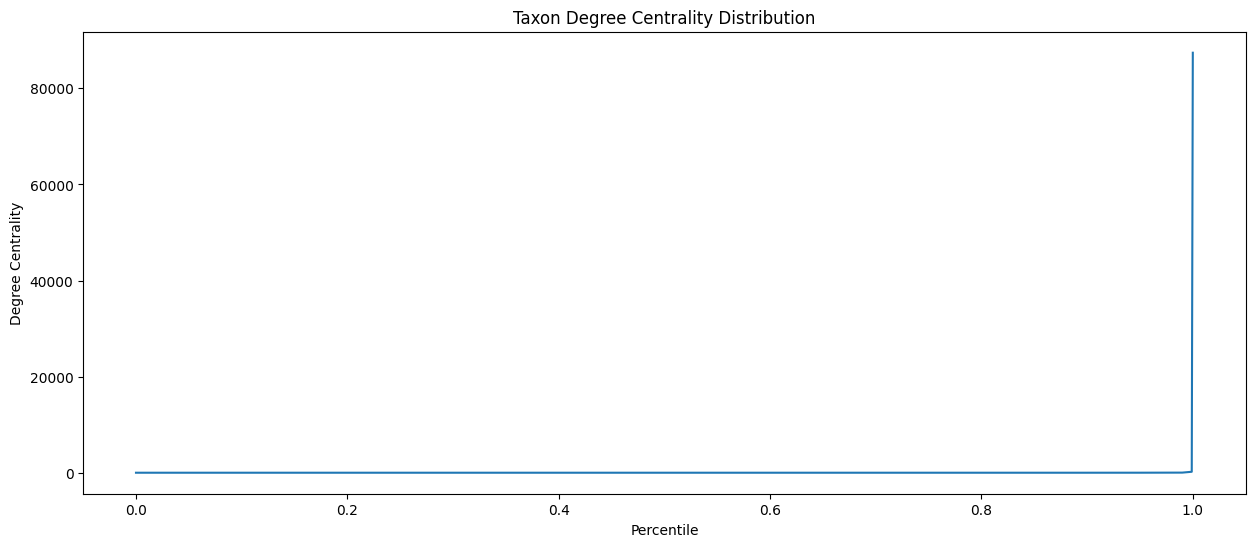

In [22]:
# Run centrality analysis

def get_degree_centrality(graph):
    result = gds.degree.stats(
        graph,
        orientation='UNDIRECTED',
    )
    return result['centralityDistribution']

def get_pagerank_centrality(graph):
    result = gds.pageRank.stats(
        graph,
    )
    return result['centralityDistribution']

def make_distribution_plot(distribution_stats, centrality_algo):
    xs = np.array([0.0, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1.0])
    ys = np.array([
        distribution_stats['min'],
        distribution_stats['p50'],
        distribution_stats['p75'],
        distribution_stats['p90'],
        distribution_stats['p95'],
        distribution_stats['p99'],
        distribution_stats['p999'],
        distribution_stats['max'],
    ])

    plt.figure(figsize=(15, 6))
    plt.plot(xs, ys)
    plt.xlabel('Percentile')
    plt.ylabel(centrality_algo)
    metadata_type = METADATA_TYPE.capitalize()
    plt.title(f'{metadata_type} {centrality_algo} Distribution')
    # plt.yscale('log')
    plt.show()

gds = get_gds_client()
projection = gds.graph.get(METADATA_PROJECTION_NAME)
stats = get_degree_centrality(projection)
# stats = get_pagerank_centrality(projection)
display(stats)

make_distribution_plot(stats, 'Degree Centrality')
# make_distribution_plot(stats, 'PageRank Centrality')

## Graphistry visualization

In [16]:
import graphistry
graphistry.register(api=3, username=os.getenv('GRAPHISTRY_USERNAME'), password=os.getenv('GRAPHISTRY_PASSWORD'))

In [7]:
DATA_DIR = '/mnt/graphdata/lpa/'

def get_tissue_nodes():
    if os.path.exists(f'{DATA_DIR}/all_tissues.csv'):
        return pd.read_csv(f'{DATA_DIR}/all_tissues.csv', index_col=False)
    query = f"""
        MATCH (t:Tissue)
        RETURN 
            id(t) as nodeId, 
            t.btoId as btoId,
            t.scientificName as scientificName
    """
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/all_tissues.csv', index=False)
    return df

def get_tissue_edges():
    if os.path.exists(f'{DATA_DIR}/tissue_edges.csv'):
        return pd.read_csv(f'{DATA_DIR}/tissue_edges.csv', index_col=False)
    query = f"""
        MATCH (t:Tissue)-[r:HAS_PARENT]->(t2:Tissue)
        RETURN 
            id(t) as sourceNodeId,
            id(t2) as targetNodeId,
            t.btoId as sourceBtoId,
            t2.btoId as targetBtoId
    """
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/tissue_edges.csv', index=False)
    return df


def get_taxon_nodes():
    if os.path.exists(f'{DATA_DIR}/taxon_nodes.csv'):
        return pd.read_csv(f'{DATA_DIR}/taxon_nodes.csv', index_col=False)
    query = """
        MATCH (t:Taxon)
        RETURN 
            id(t) as nodeId,
            t.taxId as appId,
            t.taxId as taxId
    """
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/taxon_nodes.csv', index=False)
    return df


def get_taxon_edges():
    if os.path.exists(f'{DATA_DIR}/taxon_edges.csv'):
        return pd.read_csv(f'{DATA_DIR}/taxon_edges.csv', index_col=False)
    query = """
        MATCH (t:Taxon)-[r:HAS_PARENT]->(t2:Taxon)
        RETURN 
            id(t) as sourceNodeId,
            id(t2) as targetNodeId,
            t.taxId as sourceTaxId,
            t2.taxId as targetTaxId
    """
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/taxon_edges.csv', index=False)
    return df


def get_virus_taxon_nodes():
    if os.path.exists(f'{DATA_DIR}/virus_taxon_nodes.csv'):
        return pd.read_csv(f'{DATA_DIR}/virus_taxon_nodes.csv', index_col=False)
    query = """
        MATCH (t:Taxon)
        WHERE (t)-[:HAS_PARENT*]->(:Taxon {taxId: '10239'})
        OR t.taxId = '10239'
        RETURN 
            id(t) as nodeId, 
            t.taxId as taxId
    """
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/virus_taxon_nodes.csv', index=False)
    return df

def get_virus_taxon_edges():
    if os.path.exists(f'{DATA_DIR}/virus_taxon_edges.csv'):
        return pd.read_csv(f'{DATA_DIR}/virus_taxon_edges.csv', index_col=False)
    query = """
        MATCH (t:Taxon)-[r:HAS_PARENT]->(t2:Taxon)
        WHERE (t)-[:HAS_PARENT*]->(:Taxon {taxId: '10239'})
        OR t.taxId = '10239'
        RETURN 
            id(t) as sourceNodeId,
            id(t2) as targetNodeId,
            t.taxId as sourceTaxId,
            t2.taxId as targetTaxId
    """
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/virus_taxon_edges.csv', index=False)
    return df

In [9]:

def get_graphistry_df(metadata_nodes, metadata_edges):
    nodes = metadata_nodes.copy()
    nodes = nodes.reset_index()

    edges = metadata_edges.copy()
    edges = edges[
        edges['sourceNodeId'].isin(nodes['nodeId']) &
        edges['targetNodeId'].isin(nodes['nodeId'])
    ]

    edges['targetNodeId'] = edges['targetNodeId'].astype(str)
    edges['sourceNodeId'] = edges['sourceNodeId'].astype(str)
    edges['weight'] = '1'
    edges['weightInt'] = 1
    edges = edges[[
        'sourceNodeId', 'targetNodeId', 'weight', 'weightInt'
    ]].astype(str)
    edges['weightInt'] = edges['weightInt'].astype('int32')
    return nodes, edges

In [11]:
if METADATA_TYPE == 'tissue':
    metadata_nodes = get_tissue_nodes()
    metadata_edges = get_tissue_edges()
    metadata_nodes['displayLabel'] = metadata_nodes['scientificName']

if METADATA_TYPE == 'taxon':
    metadata_nodes = get_virus_taxon_nodes()
    metadata_edges = get_virus_taxon_edges()
    metadata_nodes['displayLabel'] = metadata_nodes['taxId']

nodes, edges = get_graphistry_df(metadata_nodes, metadata_edges)

In [18]:
g = graphistry.bind()

g = g.bind(
    source='sourceNodeId',
    destination='targetNodeId',
    edge_weight='weightInt',
).edges(edges)

g = g.bind(
    node='nodeId',
    point_label='displayLabel',
    point_size=None,
    # point_size='numRuns',
).nodes(nodes)

params = {
    'play': 2000,
    'menu': True, 
    'info': True,
    'showArrows': True,
    'pointSize': 2.0, 
    # 'edgeCurvature': 0.5,
    'edgeOpacity': 0.25, 
    'pointOpacity': 1.0,
    # 'lockedX': False, 'lockedY': False, 'lockedR': False,
    'linLog': True, 
    'compactLayout': True,
    'strongGravity': True,
    'dissuadeHubs': False,
    'edgeInfluence': 5,
    # 'precisionVsSpeed': 0, 'gravity': 1.0, 'scalingRatio': 1.0,
    # 'showLabels': True, 'showLabelOnHover': True,
    # 'showPointsOfInterest': True, 'showPointsOfInterestLabel': True, 
    'showLabelPropertiesOnHover': True,
    'pointsOfInterestMax': 10,
}

g = g.settings(url_params=params)

g = g.addStyle(
    bg={
        'color': 'black',
})

# g = g.tree_layout()
# g = g.modularity_weighted_layout()

g = g.encode_point_color(
    'missing',
    categorical_mapping={},
    default_mapping='silver',
)


# g = g.encode_point_color(
#     'correct',
#     categorical_mapping={0: 'red', 1: 'green'},
# )

g.plot()